# Optimizing Image Classification Model With Transfer Learning and Hyper Parameter Tuning 

#### Objective
XYZ Pvt. Ltd., a leading industry consulting firm, has been hired to help the cause by 
developing an intelligent and automated AI model using TensorFlow that can predict the 
category of a structure in an image.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
import glob
from PIL import Image

import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend,mixed_precision
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom


In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
!nvidia-smi

Sat Jul  6 15:56:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8              11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
#Mixed Precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

print('Compute dtype:', policy.compute_dtype)
print('Variable dtype:', policy.variable_dtype)

Compute dtype: float16
Variable dtype: float32


# Deep Learning

In [ ]:
# Directory paths
train_path = '/content/drive/MyDrive/Historical/data/Train'
test_path = '/content/drive/MyDrive/Historical/data/Test'

There were only 10 classes in test images. Portal was missing. For easier modeling I added few images from portal in train dataset to test and deleted the same from training images

In [ ]:
# Setting parameters
img_size = (224,224) # Choose smaller image size for faster processing
img_depth = 3
btch_size = 32
Es = 10

In [ ]:
#Detect and remove corrupted image files
def check_and_remove_corrupted_image(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()  # Verify the image file integrity
        return False  # Image is not corrupted
    except (IOError, SyntaxError) as e:
        print(f"Removing corrupted image: {file_path} - {e}")
        os.remove(file_path)  # Remove corrupted image file
        return True  # Image was corrupted and removed

def scan_and_clean_directory(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            check_and_remove_corrupted_image(file_path)



In [ ]:
#Detect and remove corrupted image files
def check_and_remove_corrupted_image(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()  # Verify the image file integrity
        return False  # Image is not corrupted
    except (IOError, SyntaxError) as e:
        print(f"Removing corrupted image: {file_path} - {e}")
        os.remove(file_path)  # Remove corrupted image file
        return True  # Image was corrupted and removed
def scan_and_clean_directory(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            if file.lower().endswith(('.jpg')):  # Check if the file has .jpg or .jpeg extension
                check_and_remove_corrupted_image(file_path)

In [ ]:
# removing corrupted files in test dataset
if __name__ == "__main__":
    directory = test_path
    scan_and_clean_directory(directory)
    print("Directory scan and cleanup complete.")

Directory scan and cleanup complete.


In [ ]:
# Loading and saving the train dataset
df_train = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    shuffle=True,
    image_size=img_size,
    batch_size= btch_size
)

Found 10493 files belonging to 11 classes.


In [ ]:
# Loading and saving the test dataset
df_test = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    shuffle=True,
    image_size=img_size,
    batch_size= btch_size
)

Found 1531 files belonging to 11 classes.


In [ ]:
#Storing class names
class_names= df_train.class_names
print("The different classes in train directory are : ",class_names)
print("Number of classes in train directory  : ",len(class_names))

The different classes in train directory are :  ['altar', 'apse', 'bell_tower', 'column', 'dome(inner)', 'dome(outer)', 'flying_buttress', 'gargoyle', 'portal', 'stained_glass', 'vault']
Number of classes in train directory  :  11


In [ ]:
#Storing class names in test dataset
class_names_test= df_test.class_names
print("The different classes in test directory are : ",class_names_test)
print("Number of classes in test directory  : ",len(class_names_test))

The different classes in test directory are :  ['altar', 'apse', 'bell_tower', 'column', 'dome(inner)', 'dome(outer)', 'flying_buttress', 'gargoyle', 'portal', 'stained_glass', 'vault']
Number of classes in test directory  :  11


In [ ]:
# Identify missing classes in the test set
missing_classes = set(class_names) - set(class_names_test)
print("The missing class in test dataset is :",missing_classes)

The missing class in test dataset is : set()


In [ ]:
# Create dummy directories for the missing classes in the test set
for cls in missing_classes:
    cls_dir = os.path.join(test_path, cls)
    if not os.path.exists(cls_dir):
        os.makedirs(cls_dir)

In [ ]:
#Plot the sample images (8–10) from each class or category to gain a better understanding of each class
class_folders = "/content/drive/MyDrive/Historical/data/Train/*"

# Initialize an empty list to store image paths
image_paths = []

# Iterate over each class folder
for folder_path in glob.glob(class_folders):
    # Read all image files in the folder
    class_images = glob.glob(os.path.join(folder_path, "*.jpg"))[:8]
    image_paths.extend(class_images)

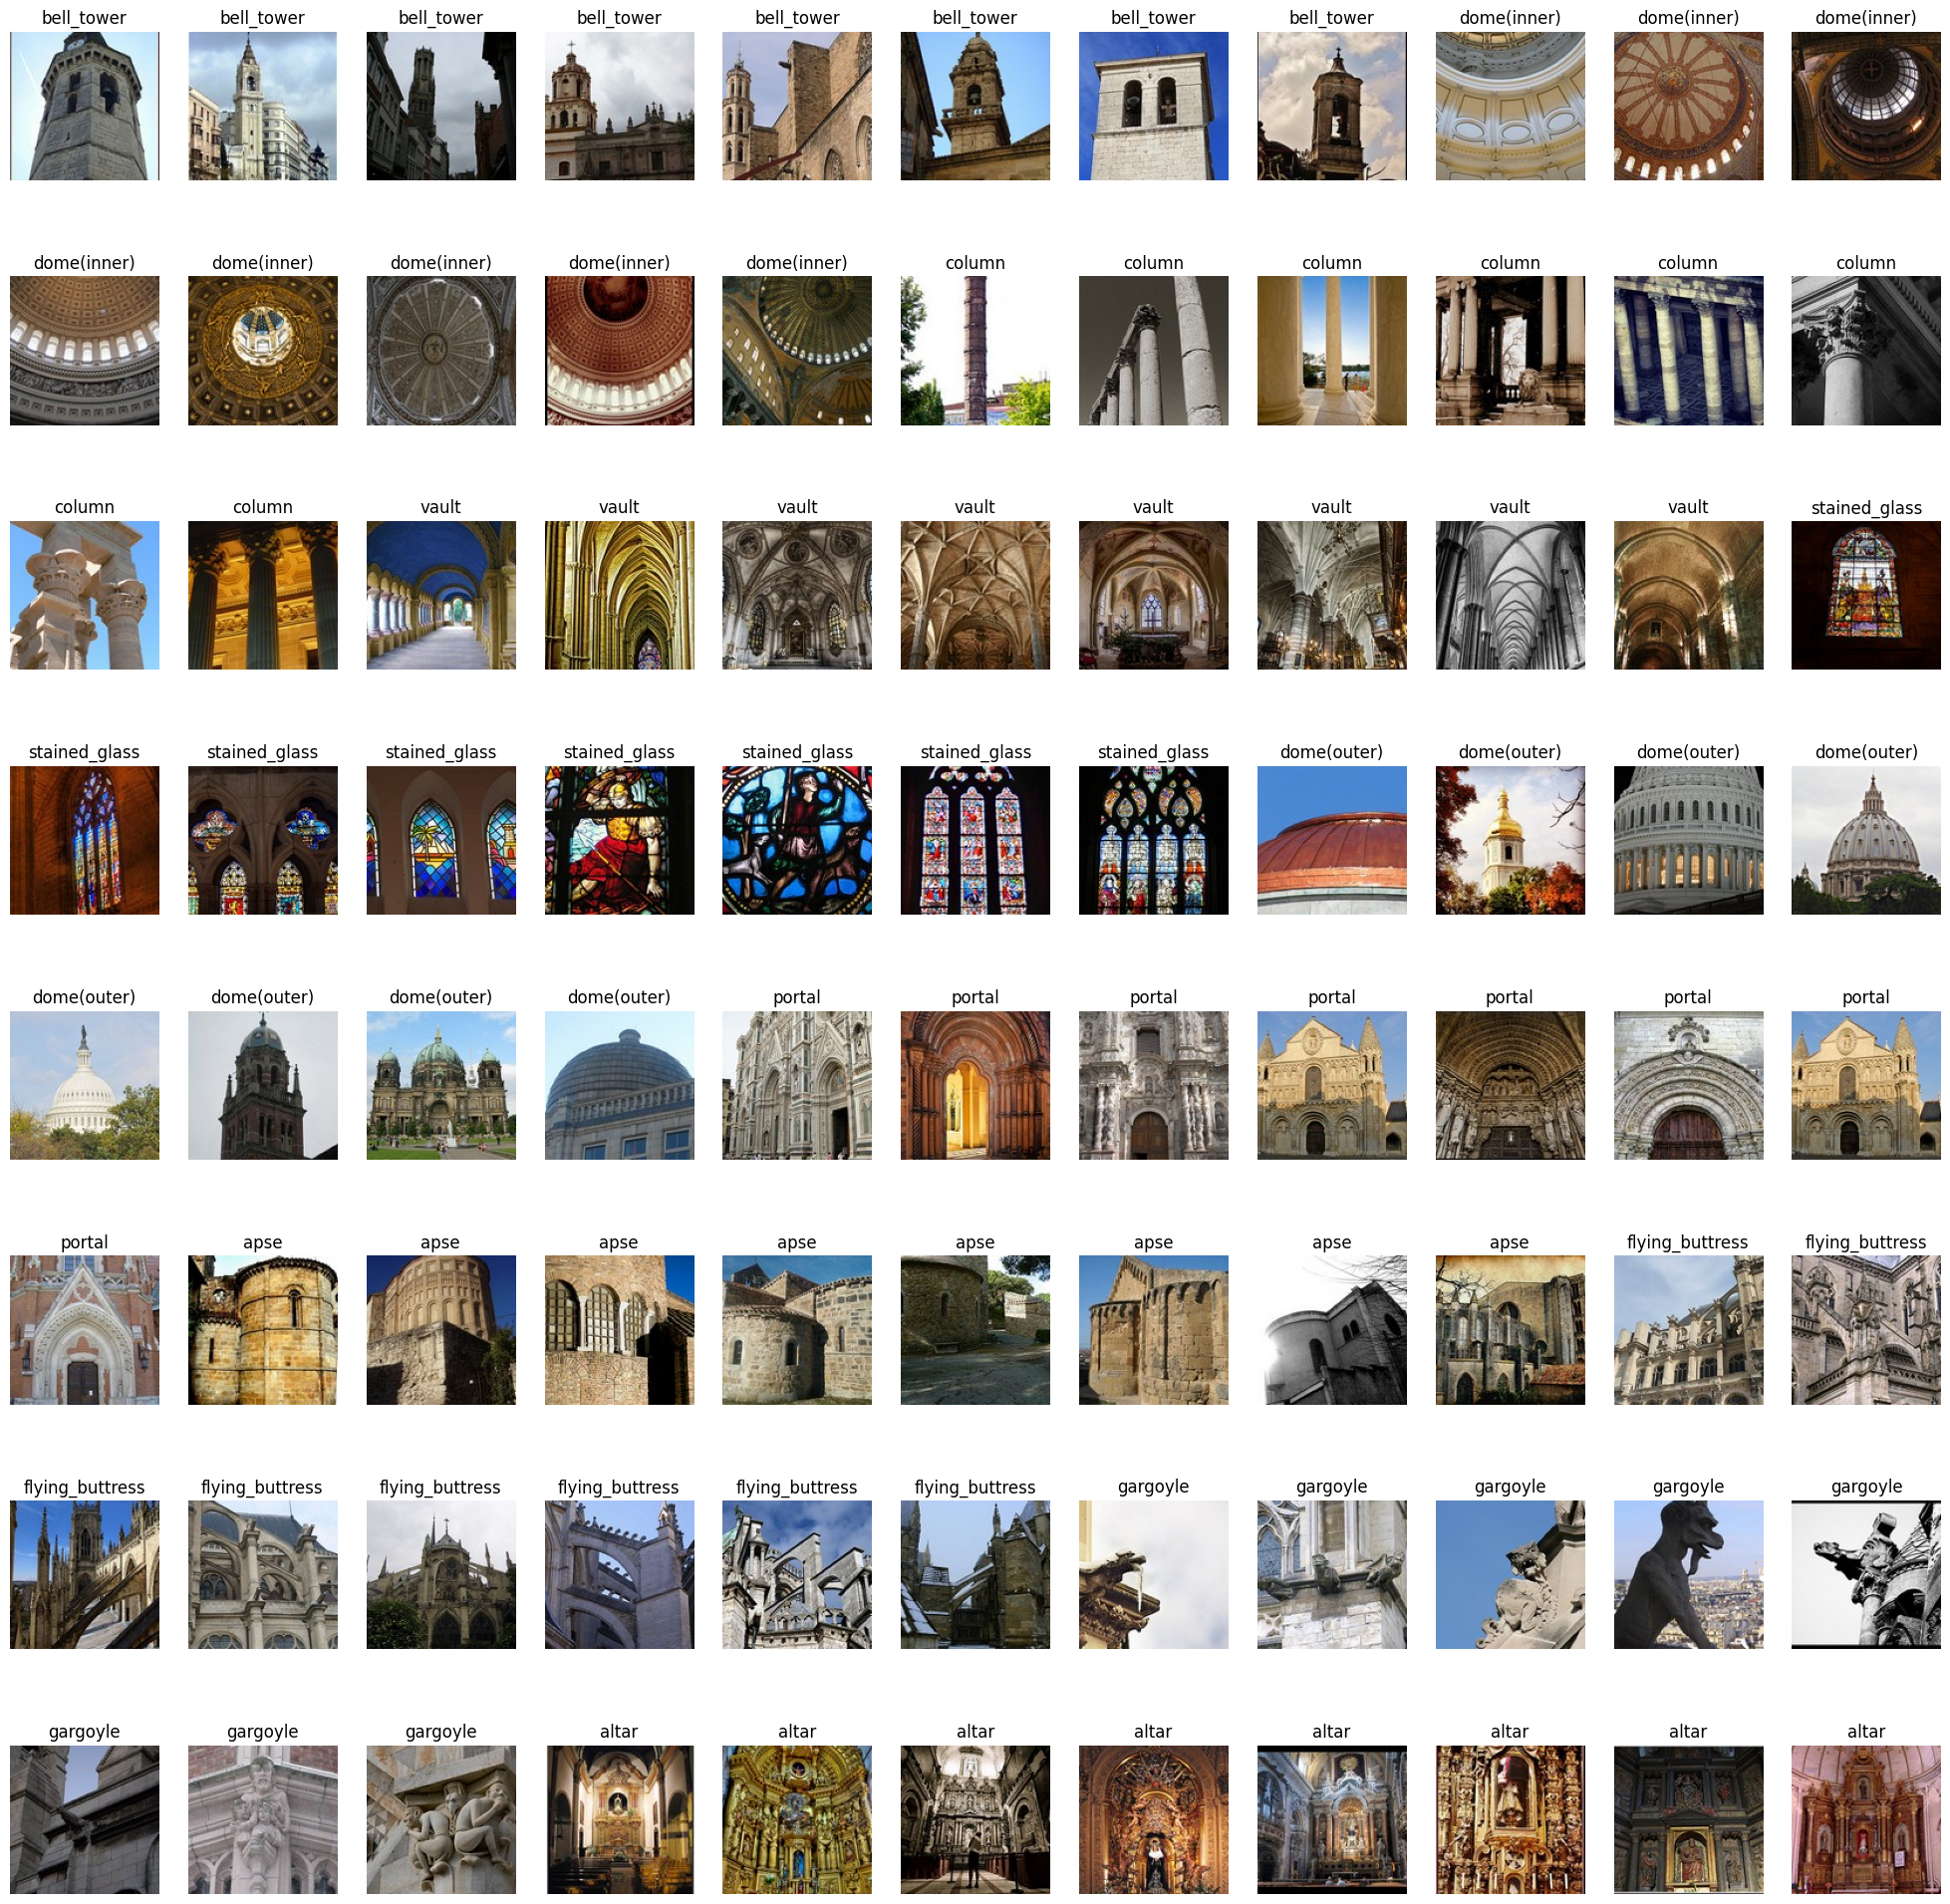

In [ ]:
# displaying images

plt.figure(figsize=(25, 25))
for idx, image_path in enumerate(image_paths):
    image = cv2.imread(image_path)
    plt.subplot(8, 11, idx + 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(os.path.basename(os.path.dirname(image_path)))#Set class name as title
    plt.axis('off')

plt.show()

In [ ]:
# Clear previous session to free memory
tf.keras.backend.clear_session()

# Model with Transfer Learning

In [ ]:
# User defined function to do basic preprocessing  on train dataset: scaling, one hot encoding
def preprocess(image, label):
    # Rescale the image to [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [img_size[0], img_size[1]])
    # One-hot encode the label
    label = tf.one_hot(label, len(class_names))
    return image, label

In [ ]:
# Load the datasets
train_ds = image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_size[0], img_size[1]),
    batch_size=btch_size)

val_ds = image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_size[0], img_size[1]),
    batch_size=btch_size)

test_ds = image_dataset_from_directory(
    test_path,
    image_size=(img_size[0], img_size[1]),
    batch_size=btch_size)

Found 10493 files belonging to 11 classes.
Using 8395 files for training.
Found 10493 files belonging to 11 classes.
Using 2098 files for validation.
Found 1531 files belonging to 11 classes.


In [ ]:
# Define AUTOTUNE for performance optimization
AUTOTUNE = tf.data.AUTOTUNE

# Apply preprocessing and performance optimizations to the datasets
train_ds_no_aug = train_ds.map(preprocess, num_parallel_calls=AUTOTUNE).cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.map(preprocess, num_parallel_calls=AUTOTUNE).cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.map(preprocess, num_parallel_calls=AUTOTUNE).cache().prefetch(buffer_size=AUTOTUNE)


In [ ]:
# Callback to stop training once validation accuracy reaches a certain threshold
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(CustomCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get('val_accuracy')
        if val_acc >= self.threshold:
            print(f"\nReached {self.threshold*100}% accuracy, stopping training.")
            self.model.stop_training = True

In [ ]:
# Load pre-trained ResNet-50 without the classification layer
model_tran = tf.keras.applications.ResNet50(include_top=False,
                                            input_shape=(img_size[0],
                                                         img_size[1],
                                                         img_depth),
                                            classes = len(class_names),
                                            weights='imagenet')

# Set pre-trained model layers to not trainable
for layer in model_tran.layers:
    layer.trainable = False

In [ ]:
# Add custom classification layer
x = tf.keras.layers.Flatten()(model_tran.output)
prediction_tran = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

# Create model object
model_tl = tf.keras.models.Model(inputs=model_tran.input, outputs=prediction_tran)

# Compile the model
model_tl.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    CustomCallback(threshold=0.97),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy', mode='max')
]

In [ ]:
# Fitting the model
model_1= model_tl.fit(train_ds_no_aug,
                epochs=Es,
                steps_per_epoch=len(train_ds_no_aug),
                validation_data=val_ds,
                validation_steps=len(val_ds),
                callbacks=callbacks)

Epoch 1/10
263/263 [==============================] - 58s 166ms/step - loss: 2.6781 - accuracy: 0.8800 - val_loss: 2.3167 - val_accuracy: 0.9276
Epoch 2/10
263/263 [==============================] - 16s 61ms/step - loss: 0.7843 - accuracy: 0.9653 - val_loss: 2.7078 - val_accuracy: 0.9290
Epoch 3/10
263/263 [==============================] - 16s 61ms/step - loss: 0.3477 - accuracy: 0.9846 - val_loss: 2.8062 - val_accuracy: 0.9390
Epoch 4/10
263/263 [==============================] - 15s 56ms/step - loss: 0.1359 - accuracy: 0.9929 - val_loss: 3.2761 - val_accuracy: 0.9376
Epoch 5/10
263/263 [==============================] - 17s 65ms/step - loss: 0.1176 - accuracy: 0.9933 - val_loss: 3.4200 - val_accuracy: 0.9357
Epoch 6/10
263/263 [==============================] - 15s 57ms/step - loss: 0.1244 - accuracy: 0.9938 - val_loss: 3.6875 - val_accuracy: 0.9347


In [ ]:
# Defining function to visualize training and validation accuracy
def plot_accuracy(history, title):
    plt.figure(figsize=(8,3))
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='val accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend();

# Defining function to visualize training and validation loss
def plot_loss(history, title):
    plt.figure(figsize=(8,3))
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.show()

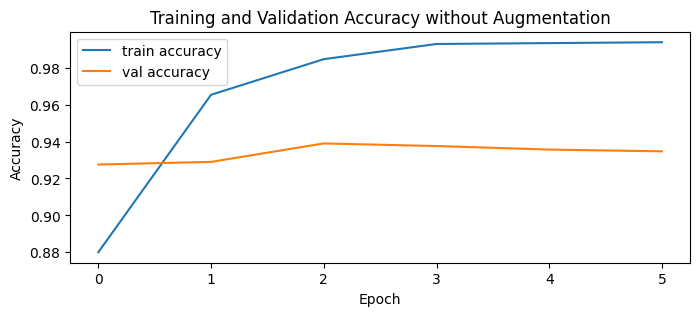

In [ ]:
# Visualize training and validation accuracy and loss
plot_accuracy(model_1, 'Training and Validation Accuracy without Augmentation')

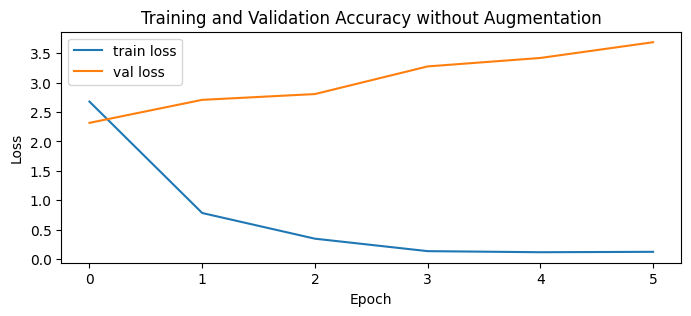

In [ ]:
# Visualize training and validation accuracy and loss
plot_loss(model_1, 'Training and Validation Accuracy without Augmentation')

A plot of learning curves shows a good fit if:

* The plot of training loss decreases to a point of stability.
* The plot of validation loss decreases to a point of stability and has a small gap with the training loss.
* An ideal model will have both accuracy curves converge to high values.

#### Observations
- The model without image augmentation technique have decent performance
- But the gap between the validation loss and the training loss is high
- Also the convergence between the training accuracy and the validation accuracy is less

In [ ]:
#Saving model
model_version=max([int(i) for i in os.listdir(
    "/content/drive/MyDrive/Historical/final_models")+[0]])+1
model_tl.save(f"/content/drive/MyDrive/Historical/final_models/{model_version}")

# Model with DCNN and Augmentation

In [ ]:
# Define the augmentation layers
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2)
])

# Function to preprocess and augment images
def preprocess_and_augment(image, label):
    # Rescale the image to [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [img_size, img_size])
    # Apply the augmentation
    image = data_augmentation(image)
    # One-hot encode the label
    label = tf.one_hot(label, len(class_names))
    return image, label

In [ ]:
# Apply preprocessing, augmentation, and performance optimizations to the train dataset
train_ds_aug = train_ds.map(preprocess, num_parallel_calls=AUTOTUNE).map(lambda x, y: (data_augmentation(x), y)).cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# DCNN Architecture
model_final = tf.keras.Sequential([
    model_tran,
    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.GlobalAveragePooling2D(),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

# Compile the model
model_final.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Fitting the model
com_final = model_final.fit(train_ds_aug,
                          epochs=Es,
                          steps_per_epoch=len(train_ds_aug),
                          validation_data=val_ds,
                          validation_steps=len(val_ds),
                          callbacks=callbacks)

Epoch 1/10
263/263 [==============================] - 186s 624ms/step - loss: 0.8274 - accuracy: 0.7565 - val_loss: 0.4663 - val_accuracy: 0.8670
Epoch 2/10
263/263 [==============================] - 17s 66ms/step - loss: 0.4028 - accuracy: 0.8784 - val_loss: 0.4997 - val_accuracy: 0.8785
Epoch 3/10
263/263 [==============================] - 17s 64ms/step - loss: 0.2532 - accuracy: 0.9198 - val_loss: 0.3269 - val_accuracy: 0.9123
Epoch 4/10
263/263 [==============================] - 15s 57ms/step - loss: 0.1859 - accuracy: 0.9435 - val_loss: 0.3971 - val_accuracy: 0.9013
Epoch 5/10
263/263 [==============================] - 16s 62ms/step - loss: 0.1147 - accuracy: 0.9649 - val_loss: 0.3875 - val_accuracy: 0.9142
Epoch 6/10
263/263 [==============================] - 15s 57ms/step - loss: 0.1013 - accuracy: 0.9700 - val_loss: 0.4539 - val_accuracy: 0.9109
Epoch 7/10
263/263 [==============================] - 16s 62ms/step - loss: 0.1013 - accuracy: 0.9694 - val_loss: 0.3734 - val_accurac

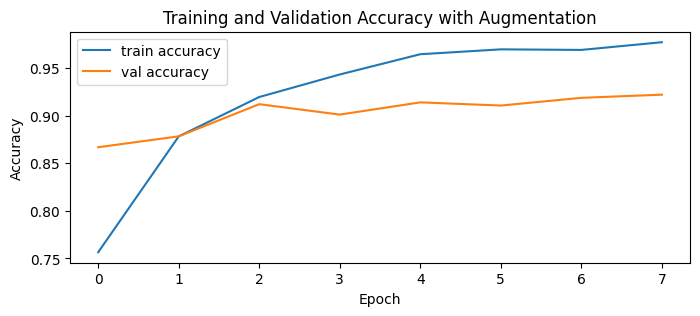

In [ ]:
# Visualize training and validation accuracy
plot_accuracy(com_final, 'Training and Validation Accuracy with Augmentation')

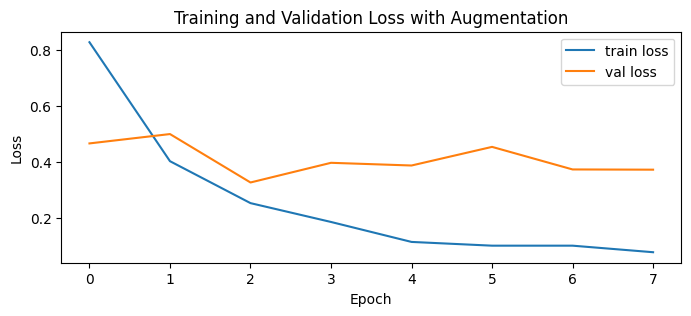

In [ ]:
# Visualize training and validation loss
plot_loss(com_final, 'Training and Validation Loss with Augmentation')

#### Observations
-After image augmentation  and adding CNN layers the performance of the model improved lot
- Eventhough the accuracy value is more over the same, the validation accuracy and the training accuracy converges in this model
- The gap between the training loss and the validation loss was reduced a lot. Which indicates better performance by the model

In [ ]:
#Saving model
model_version=max([int(i) for i in os.listdir(
    "/content/drive/MyDrive/Historical/final_models")+[0]])+1
model_final.save(f"/content/drive/MyDrive/Historical/final_models/{model_version}")

1/1 [==============================] - 0s 25ms/step
Predicted label: bell_tower


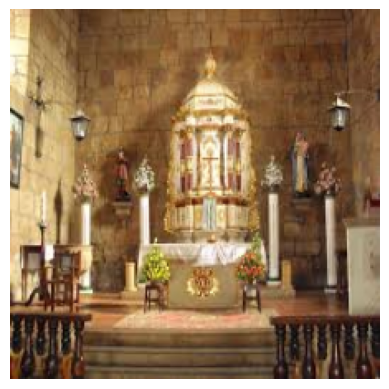

In [ ]:
# Predicting the class of test images using the final model
img = cv2.imread('/content/drive/MyDrive/Historical/data/Test/altar/00947185-77b4-4ecf-85ed-bf139c7d5a1d.jpg')
img = cv2.resize(img, (224, 224))
img = np.reshape(img, [1, 224, 224, 3])
class_probs = model_final.predict(img)
predicted_class_index = np.argmax(class_probs)
# Get the predicted class label
predicted_label = class_names[predicted_class_index]
print("Predicted label:", predicted_label)
# Display the image
plt.imshow(cv2.cvtColor(img[0], cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

1/1 [==============================] - 0s 33ms/step
Predicted label: dome(outer)


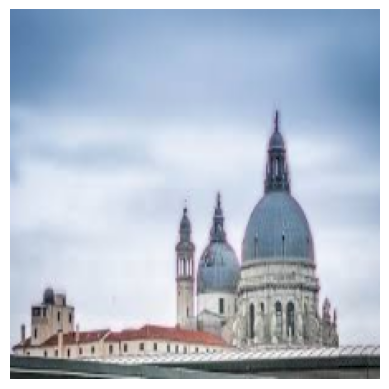

In [ ]:
# Predicting the class of test images using the final model
img = cv2.imread('/content/drive/MyDrive/Historical/data/Test/dome(outer)/038925a7-c215-4b73-bc79-a0377f482fca.jpg')
img = cv2.resize(img, (224, 224))
img = np.reshape(img, [1, 224, 224, 3])
class_probs = model_final.predict(img)
predicted_class_index = np.argmax(class_probs)
# Get the predicted class label
predicted_label = class_names[predicted_class_index]
print("Predicted label:", predicted_label)
# Display the image
plt.imshow(cv2.cvtColor(img[0], cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

**Inferences from modeling and Hyperparameter Tuning**

By using clear session and mixed precision the issues of resource exhaustion was overcomed. When a basic pretrained ResNet50 model was developed and fit without CNN layers and image augmentaion observed accuracy was in 90's. After analysing the learning curves derived the conclusion that the model performance is not good.Then hyperparameter tuning was done.Then added CNN layers and image Augmentation technique. Different number of layers, neurons, regularization, batch normalization, droupouts, epochs and batch size were tried during the trail and error method for tuning hyperparameters.

After that the learning curves improved a lot. Fluctuations in learning curves were overcomed after using correct learning rate and batch size.Drop outs  improved the performance of model considerably. A optimized DNN model with ResNet50 was finalized with minimum complexity.